In [1]:
path_to_image_folder = '/home/bjangley/VPR/VPRMethods/utrecht_experiment1_images'
correct_metadata = '/home/bjangley/VPR/VPRMethods/utrecht_experiment1_images/corrected_metadata.csv'

path_to_sequence_images = '/home/bjangley/VPR/mapillary_utils/mapillary_sequence_3/'
sequence_metadata = '/home/bjangley/VPR/mapillary_utils/mapillary_sequence_3/metadata.csv'

from utils import (
    getMasterOutout,
    scale_intrinsics,
    CameraMatrix,
    run_pnp,
    getImageFromIndex,
    pnp_to_relative_global_coords,
    get_image_html,
    plot_images_on_map,
    create_orientation_arrow,
    plotImages,
    getSequenceImageFromIndex,
    cameraMatrixMapillary
)

import matplotlib.pyplot as plt
import os
from PIL import Image


#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

#supressing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#imports for visualizing matches
import numpy as np


#these are the correct locations (edited accordingly in the corrected_metadata.csv file, the image exif params
#are not accurate)
pins = [[15,25,24,65,47,42,41,36,34], #pin[index][:] are all the pins associated to correct_locations[index]
        [13,16,23,58,63,8],
        [14,33,26,35,7],
        [57,53,50,46,44,40,43,37,30,20,12,19,9,17],
        [2,3,4,5,6,28,29,31,51,66,67],
        [39,22,38,62,59,55,52,48],
        [18,10,11,54,32,27,21]]

image_to_pin = {}
for i,j in enumerate(pins):
    for item in j:
        image_to_pin[item]=i


correct_locations = [[52.09192647667911, 5.11734847068606],
                     [52.091818536510274, 5.118643307088879],
                     [52.09186865280266, 5.119055402551572],
                     [52.09145378156313, 5.119650182401067],
                     [52.09124211820032, 5.120181438575621],
                     [52.09096484726034, 5.120400038611725],
                     [52.090786453607016, 5.120422837388419]]





# plot_images_on_map(correct_metadata,path_to_image_folder, correct_locations)

"Show the images in one experiment (used to localize each other)"
# plotImages(pins[2], path_to_image_folder)


'Show the images in one experiment (used to localize each other)'

## Localizing Mapillary Images with Self Collected Images 

>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 2048x1536 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.2147 seconds.
Point Matches Time: 0.1604 seconds.
Number of matches before confidence mask:  738


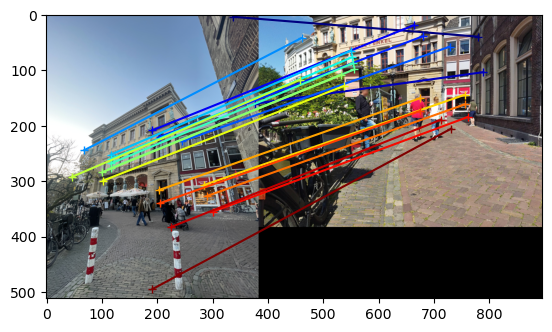

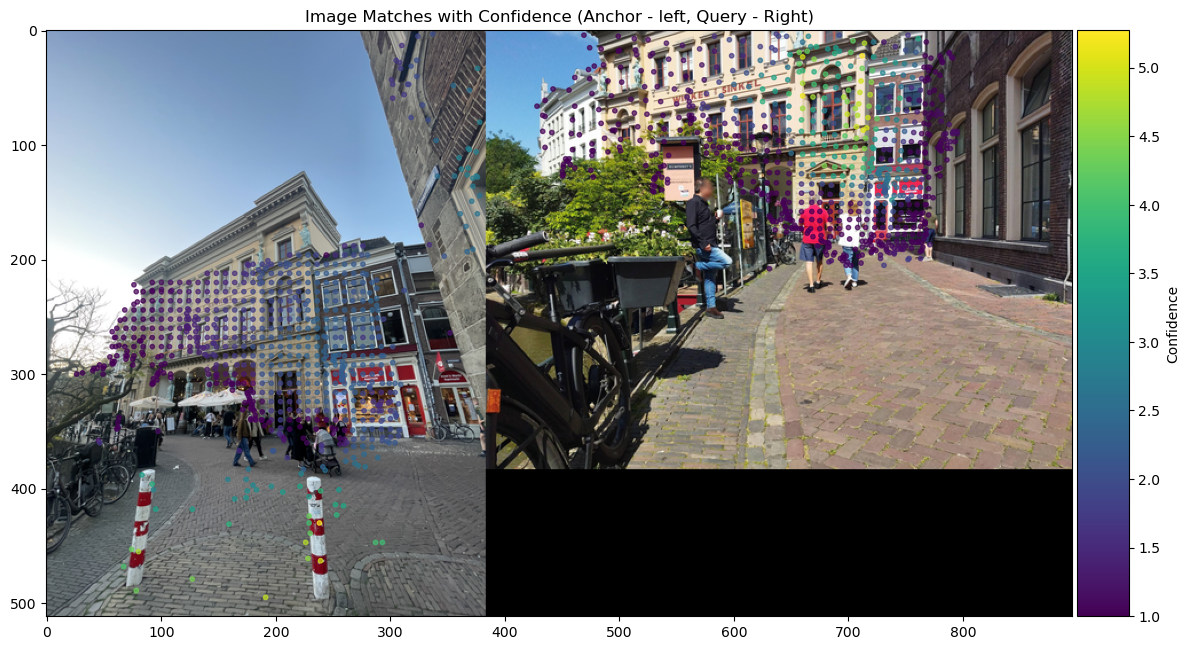

Number of matches after confidence mask:  60
Lowest Confidence Value:  3.0108871 1.3839989


/home/bjangley/VPR/mast3r/utils.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


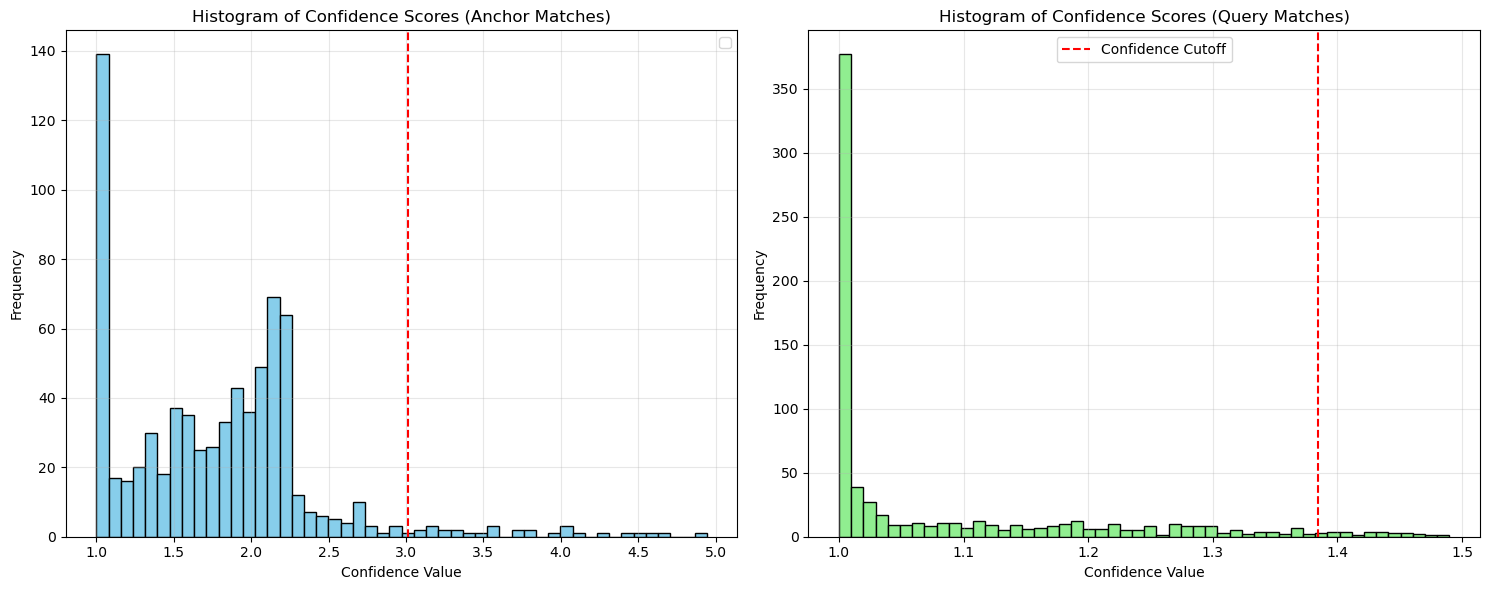

Predicted Transform:
 [-2.00621571 -1.38842861 -3.52774253]
Translation Magnitude: 4.058308613249166
Estimated new position: Lat 52.09183537254393, Lon 5.119079650316258 



In [17]:
#input

n_matches = 30
anchor_index = 35
query_index  = 2789825111191892


master_size = [512,384] #size of image used by mast3r
corrected_data=[]


anchor_image_dict, anchor_image_path_og = getImageFromIndex(anchor_index, path_to_image_folder)
anchor_image = Image.open(anchor_image_path_og)
anchor_image = anchor_image.rotate(-90, expand=True)
anchor_image_size = anchor_image.size  #original size of image


query_image_dict, query_image_path_og = getSequenceImageFromIndex(query_index,path_to_sequence_images)
query_image = Image.open(query_image_path_og)


anchor_image_path = '/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
query_image_path = '/home/bjangley/VPR/mast3r/sanity_check/query.png'
anchor_image.save(anchor_image_path, format='PNG')
query_image.save(query_image_path, format='PNG')

# K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243) #landscape
# K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[0],master_size[1])

K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) #portrait
K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[1],master_size[0])

filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches,visualizeMatches=True)

# Predicted Transform copied from visloc.py
ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

if ret_val: 

    pnp_rotation = transformation[:3, :3]  
    pnp_translation = transformation[:3, 3]  
    print("Predicted Transform:\n", pnp_translation)    
    # Calculate and print the magnitude of the translation
    translation_magnitude = np.linalg.norm([pnp_translation[0],pnp_translation[2]])
    print("Translation Magnitude:", translation_magnitude)


    anchor_location = correct_locations[image_to_pin[anchor_index]]
    

    new_lat, new_lon, _ = pnp_to_relative_global_coords(pnp_rotation, 1*pnp_translation, anchor_location[0], anchor_location[1], float(anchor_image_dict['orientation']))
    print(f"Estimated new position: Lat {new_lat}, Lon {new_lon} \n")
    corrected_data.append([anchor_index,query_index,pnp_translation,new_lat, new_lon])

Anchor Location:  [52.09186865280266, 5.119055402551572]
Query Location:  ['52.0917376', '5.1191079']
Corrected Location:  52.09183537254393 5.119079650316258



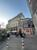
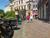

In [3]:

# Initialize the map
import folium
i = 0
corrected_location = [corrected_data[i][3], corrected_data[i][4]]
query_location = [query_image_dict['lat'],query_image_dict['long']]

# Add marker for anchor image
print("Anchor Location: ", anchor_location)
print("Query Location: ",query_location)
print("Corrected Location: ", corrected_data[i][3], corrected_data[i][4])



map_center = anchor_location
zoom_level = 20  # Desired zoom level
mymap = folium.Map(location=map_center, zoom_start=zoom_level, max_zoom=21)

folium.TileLayer('Stamen Terrain').add_to(mymap)

anchor_html = get_image_html(anchor_image_path, rotate=False)
query_html = get_image_html(query_image_path, rotate=False)



# adding anchor
folium.Marker(
    location = anchor_location,
    popup=folium.Popup(anchor_html, max_width=300),
    icon=folium.Icon(color='blue'),
    tooltip="Anchor Image"
).add_to(mymap)
create_orientation_arrow(anchor_location, anchor_image_dict['orientation'], color='blue').add_to(mymap)


# adding query

folium.Marker(
    location=query_location,
    popup=folium.Popup(query_html, max_width=300),
    icon=folium.Icon(color='red'),
    tooltip="Query"
).add_to(mymap)

create_orientation_arrow(query_location, query_image_dict['orientation'], color='red').add_to(mymap)


#adding master localization
folium.Marker(
    location=corrected_location,
    icon=folium.Icon(color='green'),
    tooltip="MAST3R Localization"
).add_to(mymap)

# Create a legend HTML
legend_html = """
<div style="position: fixed; 
             bottom: 50px; left: 50px; 
             width: 180px; height: auto; 
             z-index:9999; font-size:14px; 
             background-color:white; 
             border:2px solid grey; 
             padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-map-marker" style="color:blue"></i>&nbsp; Anchor Mapillary Location<br>
    <i class="fa fa-map-marker" style="color:red"></i>&nbsp; Query Mapillary Location<br>
    <i class="fa fa-map-marker" style="color:green"></i>&nbsp; MAST3R Localization<br>
</div>
"""

# Add the legend to the map using DivIcon
mymap.get_root().html.add_child(folium.Element(legend_html))

display(mymap)






In [4]:
print(anchor_image_size)

(3024, 4032)


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 2048x1536 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 2048x1536 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.2277 seconds.
Point Matches Time: 0.1231 seconds.
Number of matches before confidence mask:  652


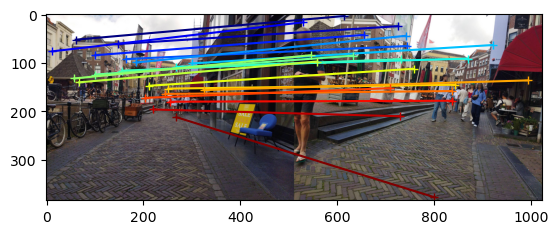

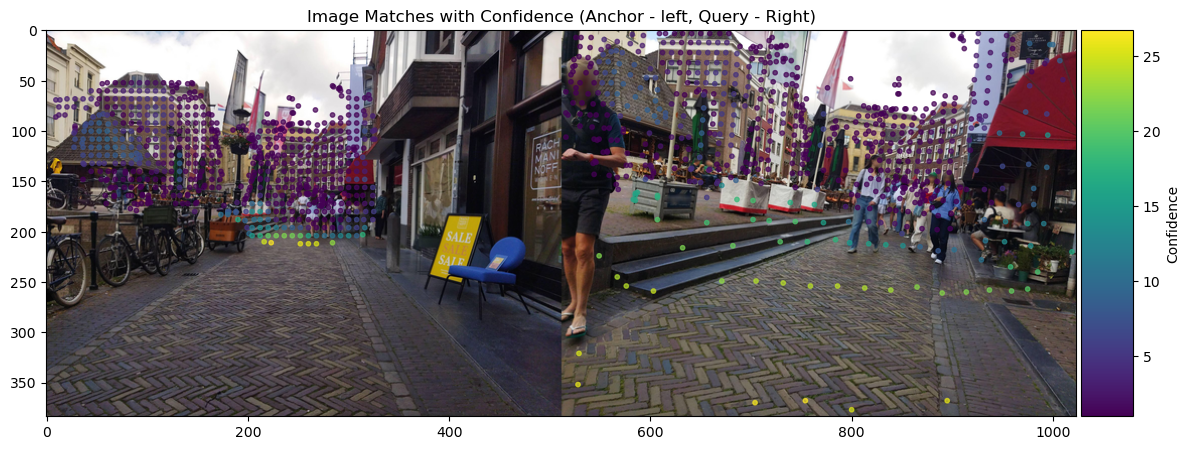

Number of matches after confidence mask:  35
Lowest Confidence Value:  3.3418489 6.3098383


/home/bjangley/VPR/mast3r/utils.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


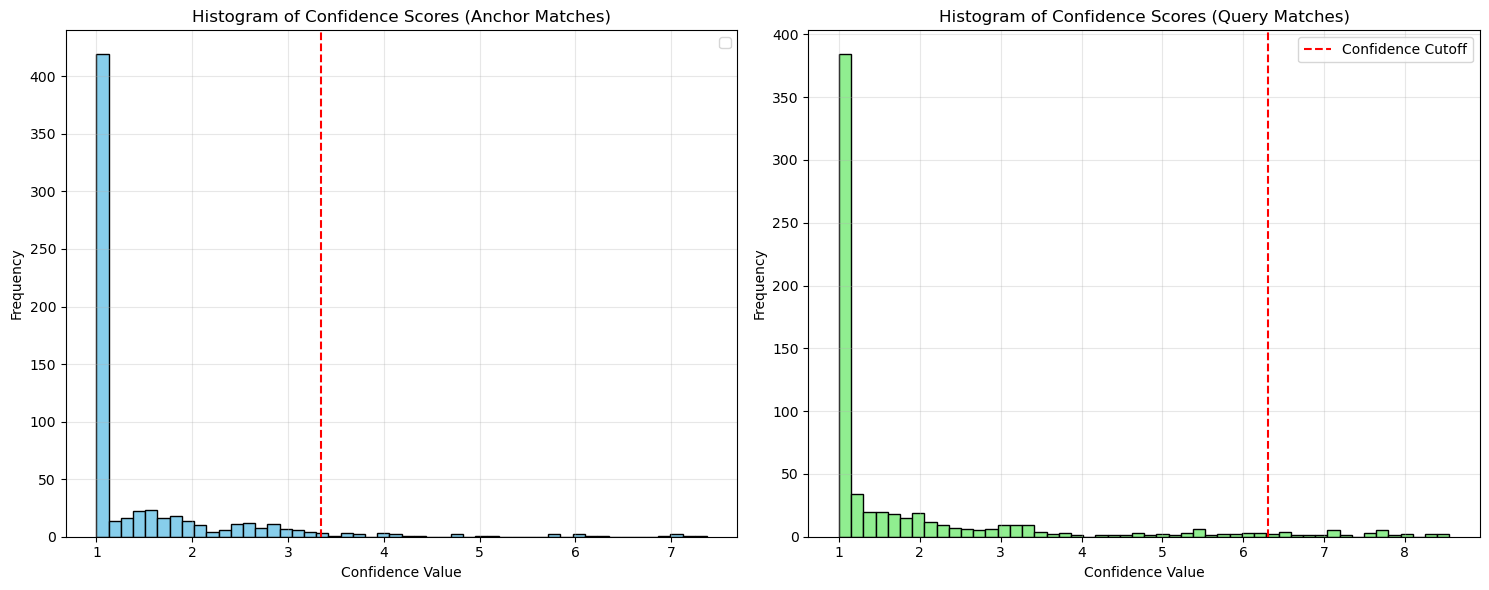

Predicted Transform:
 [ 0.05492109 -0.26487762  4.49278775]
Translation Magnitude: 4.493123421698575
Estimated new position: Lat 52.09070504493399, Lon 5.120364250857993 



In [15]:
#input
path_to_sequence1 = '/home/bjangley/VPR/mapillary_utils/mapillary_sequence_with_intrinsics/'
path_to_sequence2 = '/home/bjangley/VPR/mapillary_utils/mapillary_sequence_3/'

n_matches = 30

#example = 1
anchor_index = 795769582707143 #seq2
query_index  = 1089145919880234 #seq2

#example 2
# anchor_index = 462335223430131 #seq2
# query_index  = 171239249115822 #seq1

master_size = [512,384] #size of image used by mast3r
corrected_data=[]


anchor_image_dict, anchor_image_path_og = getSequenceImageFromIndex(anchor_index, path_to_sequence2)
anchor_image = Image.open(anchor_image_path_og)
anchor_image = anchor_image
anchor_image_size = anchor_image.size  #original size of image


query_image_dict, query_image_path_og = getSequenceImageFromIndex(query_index,path_to_sequence2)
query_image = Image.open(query_image_path_og)


anchor_image_path = '/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
query_image_path = '/home/bjangley/VPR/mast3r/sanity_check/query.png'
anchor_image.save(anchor_image_path, format='PNG')
query_image.save(query_image_path, format='PNG')


K = cameraMatrixMapillary(float(anchor_image_dict['f']), anchor_image_size[0],anchor_image_size[1])
K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[0],master_size[1])

k1 = anchor_image_dict['k1']
k2 = anchor_image_dict['k2']
dist_coeffs = np.array([k1, k2, 0, 0, 0], dtype=np.float32)

filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches,visualizeMatches=True)

# Predicted Transform copied from visloc.py
ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32),dist_coeffs)

if ret_val: 

    pnp_rotation = transformation[:3, :3]  
    pnp_translation = transformation[:3, 3]  
    print("Predicted Transform:\n", pnp_translation)    
    # Calculate and print the magnitude of the translation
    translation_magnitude = np.linalg.norm([pnp_translation[0],pnp_translation[2]])
    print("Translation Magnitude:", translation_magnitude)


    anchor_location = [float(anchor_image_dict['lat']),float(anchor_image_dict['long'])]
    

    new_lat, new_lon, _ = pnp_to_relative_global_coords(pnp_rotation, 1*pnp_translation, anchor_location[0], anchor_location[1], float(anchor_image_dict['orientation']))
    print(f"Estimated new position: Lat {new_lat}, Lon {new_lon} \n")
    corrected_data.append([anchor_index,query_index,pnp_translation,new_lat, new_lon])

In [6]:
print(anchor_image_size, master_size, K_scaled)

(2048, 1536) [512, 384] [[224.79448726   0.         256.        ]
 [  0.         168.59586545 192.        ]
 [  0.           0.           1.        ]]


Anchor Location:  [52.0906689, 5.1203935]
Query Location:  ['52.0907399', '5.1203225']
Corrected Location:  [52.09070504493399, 5.120364250857993]



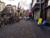
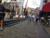

In [16]:

# Initialize the map
import folium
i = 0
corrected_location = [corrected_data[i][3], corrected_data[i][4]]
query_location = [query_image_dict['lat'],query_image_dict['long']]

# Add marker for anchor image
print("Anchor Location: ", anchor_location)
print("Query Location: ",query_location)
print("Corrected Location: ", corrected_location)



map_center = anchor_location
zoom_level = 20  # Desired zoom level
mymap = folium.Map(location=map_center, zoom_start=zoom_level, max_zoom=21)

folium.TileLayer('Stamen Terrain').add_to(mymap)

anchor_html = get_image_html(anchor_image_path, rotate=False)
query_html = get_image_html(query_image_path, rotate=False)



# adding anchor
folium.Marker(
    location = anchor_location,
    popup=folium.Popup(anchor_html, max_width=300),
    icon=folium.Icon(color='blue'),
    tooltip="Anchor Image"
).add_to(mymap)
create_orientation_arrow(anchor_location, anchor_image_dict['orientation'], color='blue').add_to(mymap)


# adding query

folium.Marker(
    location=query_location,
    popup=folium.Popup(query_html, max_width=300),
    icon=folium.Icon(color='red'),
    tooltip="Query"
).add_to(mymap)

create_orientation_arrow(query_location, query_image_dict['orientation'], color='red').add_to(mymap)


#adding master localization
folium.Marker(
    location=corrected_location,
    icon=folium.Icon(color='green'),
    tooltip="MAST3R Localization"
).add_to(mymap)

# Create a legend HTML
legend_html = """
<div style="position: fixed; 
             bottom: 50px; left: 50px; 
             width: 180px; height: auto; 
             z-index:9999; font-size:14px; 
             background-color:white; 
             border:2px solid grey; 
             padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-map-marker" style="color:blue"></i>&nbsp; Anchor Mapillary Location<br>
    <i class="fa fa-map-marker" style="color:red"></i>&nbsp; Query Mapillary Location<br>
    <i class="fa fa-map-marker" style="color:green"></i>&nbsp; MAST3R Localization<br>
</div>
"""

# Add the legend to the map using DivIcon
mymap.get_root().html.add_child(folium.Element(legend_html))

display(mymap)




